## CS310 Natural Language Processing
## Assignment 4. Long Short Term Memory (LSTM) Network for Named Entity Recognition (NER)

**Total points**: 50 + (10 bonus)

In this assignment, you will implement a Long Short Term Memory (LSTM) network for Named Entity Recognition (NER). 

Re-use the code in Lab 5.

### 0. Import Necessary Libraries

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from metrics import MetricsHandler
from utils import Indexer, get_batch, load_embedding_dict, get_tag_indices_from_scores
import matplotlib.pyplot as plt

### 1. Data Preprocessing

In [29]:
TRAIN_PATH = 'data/train.txt'
DEV_PATH = 'data/dev.txt'
TEST_PATH = 'data/test.txt'
EMBEDDINGS_PATH = 'data/glove.6B.100d.txt' 
# Download from https://nlp.stanford.edu/data/glove.6B.zip
# It includes dimension 50, 100, 200, and 300.

def read_ner_data_from_connl(path_to_file):
    sentences_words = []
    sentences_tags = []
    current_words = []
    current_tags = []
    
    with open(path_to_file, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if not line:  # Blank line indicates end of sentence
                if current_words:  # Only add non-empty sentences
                    sentences_words.append(current_words)
                    sentences_tags.append(current_tags)
                current_words = []
                current_tags = []
                continue
            splitted = line.split()
            if len(splitted) == 0:
                continue
            word = splitted[0]
            if word == "-DOCSTART-":
                continue
            entity = splitted[-1]
            current_words.append(word.lower()) 
            current_tags.append(entity)
    
    if current_words:
        sentences_words.append(current_words)
        sentences_tags.append(current_tags)
    
    return sentences_words, sentences_tags

train_sentences_words, train_sentences_tags = read_ner_data_from_connl(TRAIN_PATH)
dev_sentences_words, dev_sentences_tags = read_ner_data_from_connl(DEV_PATH)
test_sentences_words, test_sentences_tags = read_ner_data_from_connl(TEST_PATH)

# Verify that words and tags are aligned
for i, (words, tags) in enumerate(zip(train_sentences_words, train_sentences_tags)):
    assert len(words) == len(tags), f"Mismatch in sentence {i}: {len(words)} words, {len(tags)} tags"

In [30]:
# Build vocabularies for words and tags
indexer_words = Indexer([word for sentence in train_sentences_words + dev_sentences_words + test_sentences_words for word in sentence])
indexer_tags = Indexer([tag for sentence in train_sentences_tags + dev_sentences_tags + test_sentences_tags for tag in sentence])
print('sizes of indexers from all data:')
print(len(indexer_words), len(indexer_tags))

sizes of indexers from all data:
26870 10


In [33]:
# Load pre-trained embeddings
embedding_dim = 100
embeddings_dict = load_embedding_dict(EMBEDDINGS_PATH)

# Create embedding matrix
embedding_matrix = torch.zeros((len(indexer_words), embedding_dim))
for word, idx in indexer_words.get_element_to_index_dict().items():
    if word in embeddings_dict:
        embedding_matrix[idx] = torch.tensor(embeddings_dict[word])
    else:
        embedding_matrix[idx] = torch.randn(embedding_dim)

print("Embedding matrix shape:", embedding_matrix.shape)
print("Vocabulary size:", len(indexer_words))

100%|██████████| 400000/400000 [00:24<00:00, 16508.58it/s]


Embedding matrix shape: torch.Size([26870, 100])
Vocabulary size: 26870


In [34]:
# Batching with padding
def get_batch_padded(sequences, targets, batch_size):
    for i in range(0, len(sequences), batch_size):
        batch_seqs = sequences[i:i + batch_size]
        batch_targets = targets[i:i + batch_size]
        padded_seqs = torch.nn.utils.rnn.pad_sequence(batch_seqs, batch_first=True, padding_value=0)
        padded_targets = torch.nn.utils.rnn.pad_sequence(batch_targets, batch_first=True, padding_value=-1)  # Use -1 for ignored targets
        yield padded_seqs, padded_targets

### 2. Build the Model

In [35]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, num_layers=2, dropout=0.2):
        super(LSTMTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, sequence):
        embeds = self.word_embeddings(sequence)
        lstm_out, _ = self.lstm(embeds)
        logits = self.fc(lstm_out)
        logprobs = F.log_softmax(logits, dim=-1)
        return logprobs

### 3. Train and Evaluate

In [38]:
labels_str = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
labels_int = list(range(len(labels_str)))

def train_model(model, train_loader, dev_loader, test_loader, optimizer, loss_func, train_metrics, dev_metrics, test_metrics, num_epochs=5, device='cpu', batch_size=128, scheduler=None):
    model.train()
    losses = []
    dev_f1_scores = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        train_metrics.collect()  
        
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = batch
            inputs = inputs.to(device)  
            targets = targets.to(device)

            output = model(inputs) 
            loss = loss_func(output.view(-1, output.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()

            scores = output.view(-1, output.size(-1)).detach().cpu().numpy()

            # Get predictions using greedy search
            predictions = get_tag_indices_from_scores(scores)
            # Flatten predictions and targets for metrics, excluding padding
            flat_predictions = []
            flat_targets = []
            pred_idx = 0  
            for i in range(len(targets)):
                for j in range(len(targets[i])):
                    if targets[i][j].item() != -1:  # Exclude padding
                        flat_predictions.append(predictions[pred_idx])
                        flat_targets.append(targets[i][j].item())
                    pred_idx += 1  
            
            train_metrics.update(flat_predictions, flat_targets)
            running_loss += loss.item() * inputs.size(0)
        scheduler.step()
        epoch_loss = running_loss / (len(train_loader) * batch_size)
        losses.append(epoch_loss)
        train_f1 = train_metrics.get_metrics()['F1-score'][-1]
        train_f1 = 0.0 if torch.isnan(torch.tensor(train_f1)) else train_f1
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train F1-score: {train_f1:.4f}")

        # Evaluate on dev set
        model.eval()
        dev_metrics.collect() 
        dev_loss = evaluate_model(model, dev_loader, loss_func, dev_metrics, device=device)
        dev_f1 = dev_metrics.get_metrics()['F1-score'][-1]
        dev_f1 = 0.0 if torch.isnan(torch.tensor(dev_f1)) else dev_f1
        dev_f1_scores.append(dev_f1)
        print(f"Epoch {epoch+1}/{num_epochs}, Dev Loss: {dev_loss:.4f}, Dev F1-score: {dev_f1:.4f}")

        # Evaluate on test set
        test_metrics.collect()
        test_loss = evaluate_model(model, test_loader, loss_func, test_metrics, device=device)
        test_f1 = test_metrics.get_metrics()['F1-score'][-1]
        test_f1 = 0.0 if torch.isnan(torch.tensor(test_f1)) else test_f1
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}")
        model.train()  

    return model, train_metrics, dev_metrics, test_metrics, losses, dev_f1_scores

def evaluate_model(model, data_loader, loss_func, eval_metrics, device='cpu', batch_size=128):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch
            inputs = inputs.to(device)  
            targets = targets.to(device)

            output = model(inputs)
            loss = loss_func(output.view(-1, output.size(-1)), targets.view(-1))
            scores = output.view(-1, output.size(-1)).detach().cpu().numpy()

            # Get predictions using greedy search
            predictions = get_tag_indices_from_scores(scores)
            # Flatten predictions and targets for metrics, excluding padding
            flat_predictions = []
            flat_targets = []
            pred_idx = 0
            for i in range(len(targets)):
                for j in range(len(targets[i])):
                    if targets[i][j].item() != -1:
                        flat_predictions.append(predictions[pred_idx])
                        flat_targets.append(targets[i][j].item())
                    pred_idx += 1
            eval_metrics.update(flat_predictions, flat_targets)
            running_loss += loss.item() * inputs.size(0)

    avg_loss = running_loss / (len(data_loader) * batch_size)
    return avg_loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

batch_size = 128

train_sequences = [torch.tensor(indexer_words.elements_to_indices(sentence), dtype=torch.long) for sentence in train_sentences_words]
train_targets = [torch.tensor(indexer_tags.elements_to_indices(sentence), dtype=torch.long) for sentence in train_sentences_tags]
dev_sequences = [torch.tensor(indexer_words.elements_to_indices(sentence), dtype=torch.long) for sentence in dev_sentences_words]
dev_targets = [torch.tensor(indexer_tags.elements_to_indices(sentence), dtype=torch.long) for sentence in dev_sentences_tags]
test_sequences = [torch.tensor(indexer_words.elements_to_indices(sentence), dtype=torch.long) for sentence in test_sentences_words]
test_targets = [torch.tensor(indexer_tags.elements_to_indices(sentence), dtype=torch.long) for sentence in test_sentences_tags]

for i, (seq, tgt) in enumerate(zip(train_sequences, train_targets)):
    assert len(seq) == len(tgt), f"Mismatch in train sequence {i}: {len(seq)} words, {len(tgt)} tags"

train_batches = list(get_batch_padded(train_sequences, train_targets, batch_size))
dev_batches = list(get_batch_padded(dev_sequences, dev_targets, batch_size))
test_batches = list(get_batch_padded(test_sequences, test_targets, batch_size))

train_metrics = MetricsHandler(labels_int)
dev_metrics = MetricsHandler(labels_int)
test_metrics = MetricsHandler(labels_int)

embedding_dim = 100
hidden_dim = 128
vocab_size = len(indexer_words)
tagset_size = len(indexer_tags)

model = LSTMTagger(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    tagset_size=tagset_size,
    num_layers=2,
    dropout=0.3
).to(device)

model.word_embeddings.weight.data.copy_(embedding_matrix.to(device))
model.word_embeddings.weight.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
loss_func = nn.NLLLoss(ignore_index=-1)

# Add warm-up scheduler
num_warmup_epochs = 3
base_lr = 1e-5
target_lr = 0.0005

def lr_lambda(epoch):
    if epoch < num_warmup_epochs:
        return (base_lr + (target_lr - base_lr) * (epoch / num_warmup_epochs)) / target_lr
    return 1.0

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

num_epochs = 10
model, train_metrics, dev_metrics, test_metrics, losses, dev_f1_scores = train_model(
    model,
    train_loader=train_batches,
    dev_loader=dev_batches,
    test_loader=test_batches,
    optimizer=optimizer,
    loss_func=loss_func,
    train_metrics=train_metrics,
    dev_metrics=dev_metrics,
    test_metrics=test_metrics,
    num_epochs=num_epochs,
    device=device,
    batch_size=batch_size,
    scheduler=scheduler
)

# Evaluate on test set
model.eval()
test_metrics.collect()
test_loss = evaluate_model(model, test_batches, loss_func, test_metrics, device=device, batch_size=batch_size)
test_f1 = test_metrics.get_metrics()['F1-score'][-1]
print(f"\nFinal Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}")

# Save the model
torch.save(model.state_dict(), 'lstm.pth')
print("Model saved to 'lstm.pth'")

print("\nFirst 5 Dev F1-scores:", dev_f1_scores[:5])

'''
Epoch 1/10, Train Loss: 2.1531, Train F1-score: 0.0000
Epoch 1/10, Dev Loss: 2.0282, Dev F1-score: 0.0000
Epoch 1/10, Test Loss: 2.0789, Test F1-score: 0.0000
Epoch 2/10, Train Loss: 0.9190, Train F1-score: 0.4543
Epoch 2/10, Dev Loss: 0.7377, Dev F1-score: 0.9086
Epoch 2/10, Test Loss: 0.7639, Test F1-score: 0.9043
Epoch 3/10, Train Loss: 0.6492, Train F1-score: 0.9088
Epoch 3/10, Dev Loss: 0.5202, Dev F1-score: 0.9086
Epoch 3/10, Test Loss: 0.5435, Test F1-score: 0.9043
Epoch 4/10, Train Loss: 0.4319, Train F1-score: 0.2176
Epoch 4/10, Dev Loss: 0.3246, Dev F1-score: 0.3336
Epoch 4/10, Test Loss: 0.3406, Test F1-score: 0.3307
Epoch 5/10, Train Loss: 0.2865, Train F1-score: 0.5378
Epoch 5/10, Dev Loss: 0.2368, Dev F1-score: 0.7605
Epoch 5/10, Test Loss: 0.2496, Test F1-score: 0.6345
Epoch 6/10, Train Loss: 0.2229, Train F1-score: 0.7175
Epoch 6/10, Dev Loss: 0.1973, Dev F1-score: 0.7701
Epoch 6/10, Test Loss: 0.2114, Test F1-score: 0.7721
Epoch 7/10, Train Loss: 0.1891, Train F1-score: 0.7939
Epoch 7/10, Dev Loss: 0.1713, Dev F1-score: 0.8061
Epoch 7/10, Test Loss: 0.1887, Test F1-score: 0.8032
Epoch 8/10, Train Loss: 0.1666, Train F1-score: 0.8256
Epoch 8/10, Dev Loss: 0.1540, Dev F1-score: 0.8400
Epoch 8/10, Test Loss: 0.1740, Test F1-score: 0.8216
Epoch 9/10, Train Loss: 0.1504, Train F1-score: 0.8437
Epoch 9/10, Dev Loss: 0.1422, Dev F1-score: 0.8599
Epoch 9/10, Test Loss: 0.1646, Test F1-score: 0.8319
Epoch 10/10, Train Loss: 0.1376, Train F1-score: 0.8585
Epoch 10/10, Dev Loss: 0.1339, Dev F1-score: 0.8687
Epoch 10/10, Test Loss: 0.1565, Test F1-score: 0.8409

Final Test Loss: 0.1565, Test F1-score: 0.8484
'''

Using device: cuda


c:\Users\aaron\Documents\CS310_NLP\assignment4\metrics.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return x[1, 1]/(x[1, 1] + x[0, 1])
c:\Users\aaron\Documents\CS310_NLP\assignment4\metrics.py:33: RuntimeWarning: Mean of empty slice
  self.metrics_dict[metric].append(np.nanmean(values))
c:\Users\aaron\Documents\CS310_NLP\assignment4\metrics.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return x[1, 1] / (x[1, 0] + x[1, 1])


Epoch 1/10, Train Loss: 2.1531, Train F1-score: 0.0000
Epoch 1/10, Dev Loss: 2.0282, Dev F1-score: 0.0000
Epoch 1/10, Test Loss: 2.0789, Test F1-score: 0.0000


c:\Users\aaron\Documents\CS310_NLP\assignment4\metrics.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return ((1 + beta**2)*precision*recall)/(beta**2 * precision + recall)


Epoch 2/10, Train Loss: 0.9190, Train F1-score: 0.4543
Epoch 2/10, Dev Loss: 0.7377, Dev F1-score: 0.9086
Epoch 2/10, Test Loss: 0.7639, Test F1-score: 0.9043
Epoch 3/10, Train Loss: 0.6492, Train F1-score: 0.9088
Epoch 3/10, Dev Loss: 0.5202, Dev F1-score: 0.9086
Epoch 3/10, Test Loss: 0.5435, Test F1-score: 0.9043
Epoch 4/10, Train Loss: 0.4319, Train F1-score: 0.2176
Epoch 4/10, Dev Loss: 0.3246, Dev F1-score: 0.3336
Epoch 4/10, Test Loss: 0.3406, Test F1-score: 0.3307
Epoch 5/10, Train Loss: 0.2865, Train F1-score: 0.5378
Epoch 5/10, Dev Loss: 0.2368, Dev F1-score: 0.7605
Epoch 5/10, Test Loss: 0.2496, Test F1-score: 0.6345
Epoch 6/10, Train Loss: 0.2229, Train F1-score: 0.7175
Epoch 6/10, Dev Loss: 0.1973, Dev F1-score: 0.7701
Epoch 6/10, Test Loss: 0.2114, Test F1-score: 0.7721
Epoch 7/10, Train Loss: 0.1891, Train F1-score: 0.7939
Epoch 7/10, Dev Loss: 0.1713, Dev F1-score: 0.8061
Epoch 7/10, Test Loss: 0.1887, Test F1-score: 0.8032
Epoch 8/10, Train Loss: 0.1666, Train F1-score

### 3. Plot Graph

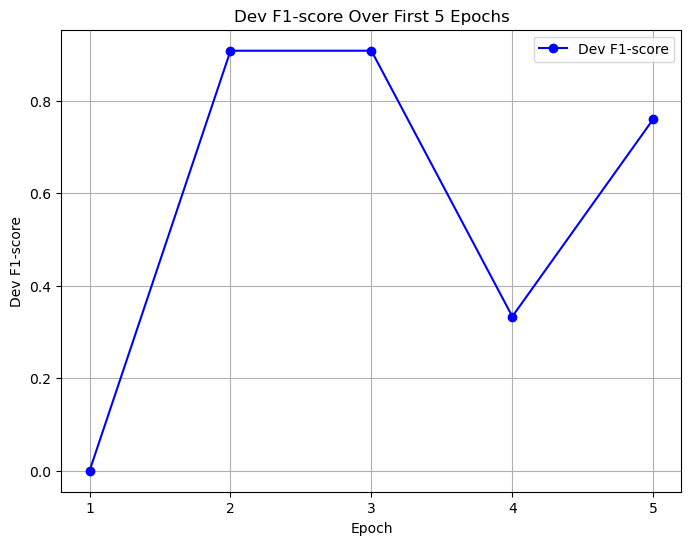

In [40]:
first_5_dev_f1 = dev_f1_scores[:5]
epochs = list(range(1, 6))

plt.figure(figsize=(8, 6))
plt.plot(epochs, first_5_dev_f1, marker='o', linestyle='-', color='b', label='Dev F1-score')
plt.title('Dev F1-score Over First 5 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dev F1-score')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()